Load Python and PyhtonFortran packages

In [1]:
#setup 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import network_impainting_tools as NetImp
from ExampleDerivedTypes import ( Dmkcontrols,
                                  Abstractgeometry,
                                  Dmkinputsdata,
                                  example_monge_kantorovich_spectral,
                                  otpdmk,data2grids,dmkp1p0_steady_data,
                                  build_subgrid_rhs,
                                  Tdenspotentialsystem)

import sys
sys.path.append('../../globals/python_timedata')
import timedata as td
sys.path.append('../preprocess/2d_assembly/')
import example_grid as ex_grid
import example_forcing as ex_forcing
import timecell as timecell
import make_optimal_tdens as make_opttdens
import meshtools as mt
sys.path.append('../preprocess/')
import grids as grids
import forcings as forcings
import optimal_tdens as opttdens

Define domain and grid for the discretization.

Pre-build examples are define in  "../preprocess/2d_assembly/example_grid".

In [2]:
# set grid
ndiv=32


length=1.0/float(ndiv)
flag_grid='rect_cnst'
extra_grid=' '

# build grid
topol,coord,flags = grids.assembly_grid(flag_grid,length,extra_grid)

# init. Fortan structure for grid and subgrid
grid,subgrid = grids.py2fortran(topol,coord)   

# write to file
mt.write_grid(coord,topol,'grid.dat','dat')

3174


Define forcing term $f=f^{+}-f^{-}$

Pre-build examples are define in  "../preprocess/2d_assembly/example_grid".

In [3]:
# set forcing term
flag_source='rect_cnst'
flag_sink='rect_cnst'
extra_source=''
extra_sink=''
forcing = forcings.assembly_forcing(grid.bar_cell.transpose(),flags,
                                    flag_source,flag_sink,
                                    extra_source,extra_sink)
# write 2 file
td.write_steady_timedata('forcing.dat',forcing.reshape([len(forcing),1]))

3174
rect_cnst
Sink flag =rect_cnst
1 1
[0.] [2.]
[0.] [2.]


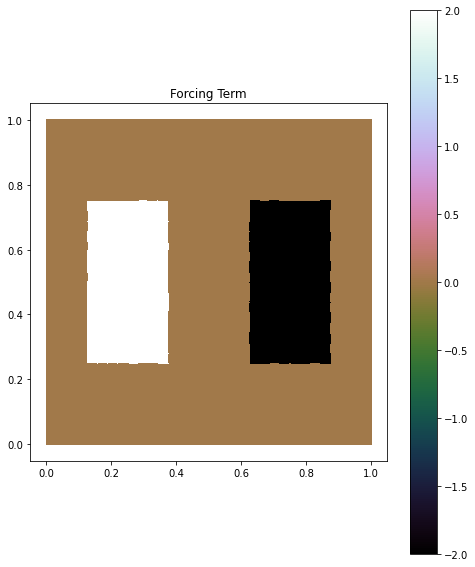

In [4]:
#Create triangulation.
triang = mtri.Triangulation(coord[:,0], coord[:,1], topol)
fig1, ax1 = plt.subplots(figsize=(8, 10))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, forcing, cmap='cubehelix')
fig1.colorbar(tpc)
ax1.set_title('Forcing Term')
plt.show()

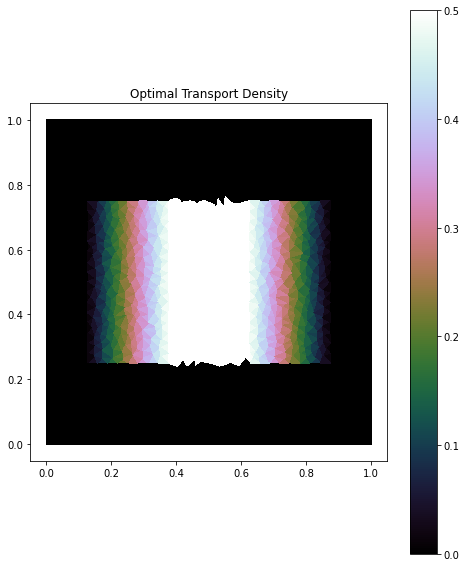

In [5]:
#
# build optimal transport density
#
optdens_cell=opttdens.assembly_optimal_tdens(
    grid.bar_cell.transpose(),flags,
    flag_grid,flag_source,flag_sink,
    extra_source,extra_sink)

#Create triangulation.
triang = mtri.Triangulation(coord[:,0], coord[:,1], topol)
fig1, ax1 = plt.subplots(figsize=(8, 10))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, optdens_cell, cmap='cubehelix')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density')
plt.show()

Initializate and set input data for dmk solver.

We rhs, penalty_weight, weight,kappa,pflux, etc.


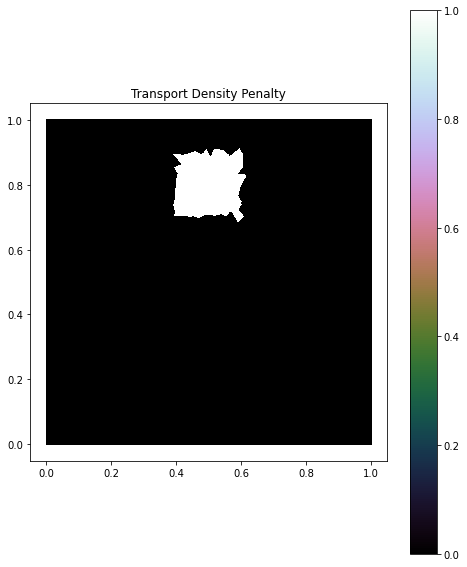

In [6]:
#
# init input data python-fortran structure 
#
dmkin=Dmkinputsdata.DmkInputs()
# Last true set all varaible to default : pmass,pflux,decay kappa=1
Dmkinputsdata.dmkinputs_constructor(dmkin,6,grid.ncell, subgrid.nnode,True)
# set rhs given by forcing = source-sink
build_subgrid_rhs(subgrid, dmkin.rhs, forcing,np.zeros(grid.nnode))
# set optimal transpost density
Dmkinputsdata.setopttdens(dmkin,0,optdens_cell)
# set ode parameters
dmkin.pflux=1.5
# set penalty
bar_cell=mt.make_bar(coord,topol)
def penalty_fun(x,y):
    #print(icell,x,y,(x>0.4) and (x<0.6) and (y> 0.6) and (y<0.8))

    if ((x>0.4) and (x<0.6) and (y> 0.7) and (y<0.9)):
        penalty=1
    else:
        penalty=0
        
    return penalty
for icell,bar in enumerate(bar_cell):
    dmkin.penalty[icell]=penalty_fun(bar[0],bar[1])
dmkin.penalty_factor=10
dmkin.penalty_weight=dmkin.penalty
# show penalty
triang = mtri.Triangulation(coord[:,0], coord[:,1], topol)
fig1, ax1 = plt.subplots(figsize=(8, 10))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, dmkin.penalty , cmap='cubehelix')
fig1.colorbar(tpc)
ax1.set_title('Transport Density Penalty')
plt.show()

In [13]:
#
# init set controls
#
#
# init set controls
#
ctrl = Dmkcontrols.DmkCtrl()
# globals controls
ctrl.selection=0
ctrl.threshold_tdens=1e-10
ctrl.debug=0
ctrl.min_tdens = 1e-13


# linear solver ctrl
ctrl.linear_solver='ITERATIVE'
ctrl.linear_solver='MG'
ctrl.krylov_scheme='PCG'
ctrl.prec_type='IC'
ctrl.n_fillin=30
ctrl.tol_fillin=1e-5
ctrl.relax4prec=1e-09
ctrl.relax_direct=1e-12
ctrl.imax=100
ctrl.iprt=0
ctrl.tolerance_linear_solver=1e-12
ctrl.tolerance_linear_newton=1e-4
ctrl.isol=1
ctrl.iort=1
ctrl.fpcg_max_restart=5
ctrl.tol_internal=1e-05
ctrl.imax_internal=30
ctrl.iprt_internal=-1


# time  ctrl
# evolution controls
ctrl.max_time_iterations=100
ctrl.tolerance_system_variation=1e-04
# time stepping scheme
ctrl.time_discretization_scheme=7
# time stepping scheme controls
ctrl.newton_method=100
ctrl.max_nonlinear_iterations=20
ctrl.tol_nonlinear=1e-08
ctrl.max_restart_update=20
ctrl.epsilon_w22=1e-8

# time step size controls
ctrl.deltat = 1
ctrl.deltat_control=3
ctrl.deltat_expansion_rate=2
ctrl.deltat_lower_bound=0.01
ctrl.deltat_upper_bound=1000


# info , saving ctrl
ctrl.info_update=3
ctrl.info_state=2
ctrl.id_save_dat=3
ctrl.lun_statistics=10
ctrl.lun_out=6
ctrl.lun_tdens = 1234
ctrl.fn_tdens='tdens.dat'
ctrl.lun_pot=1235
ctrl.fn_pot='pot.dat'


ctrl.max_nonlinear_iterations=20
ctrl.tolerance_nonlinear=1e-09
ctrl.relax4prec=1e-10
ctrl.tolerance_system_variation=1e-10


In [14]:
#
# init tdens potential datadmkp1p0_steady_data
#time_discretization_scheme 
tdpot=Tdenspotentialsystem.tdpotsys()
Tdenspotentialsystem.tdpotsys_constructor(tdpot,0,grid.ncell, subgrid.nnode,1)
tdpot.tdens[:]=1.0
tdpot.pot[:]=0.0

In [15]:
# solve with dmk
info=0
dmkp1p0_steady_data(grid, subgrid, tdpot, dmkin, ctrl, info)
print(info)

0


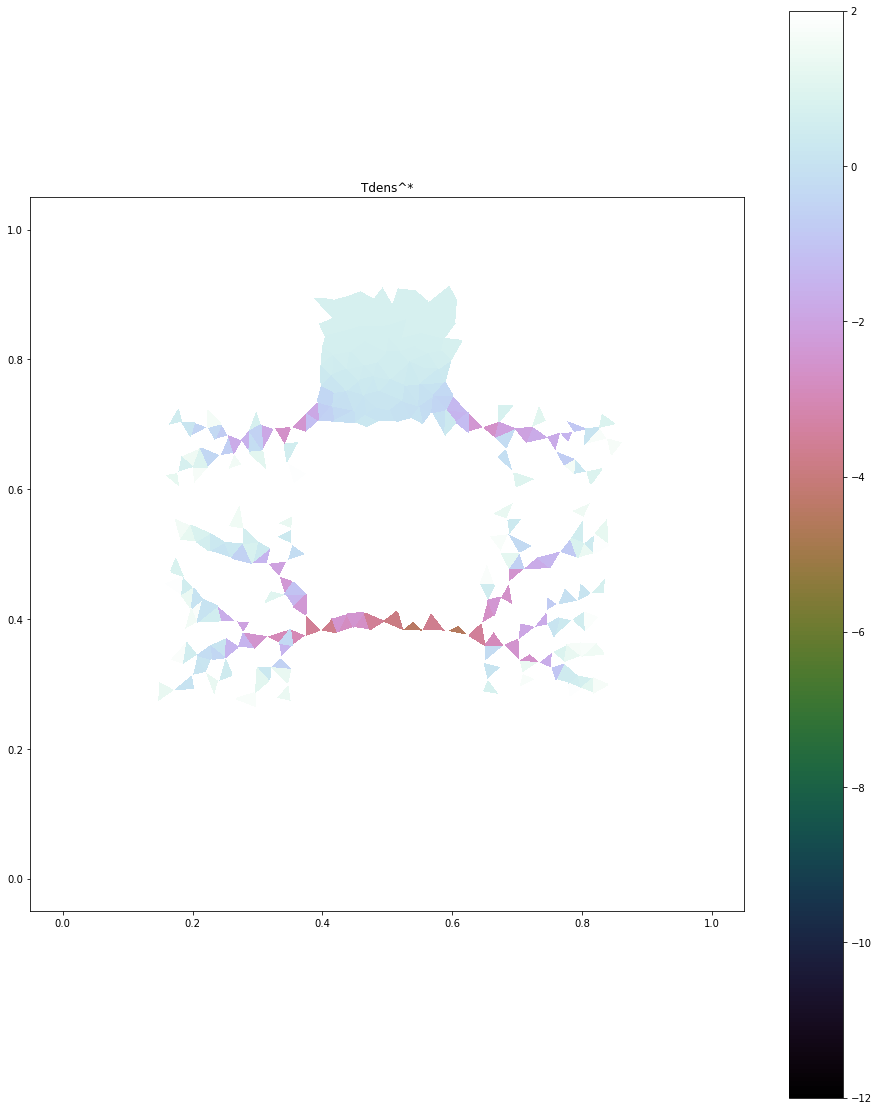

In [16]:
#Create triangulation.
triang = mtri.Triangulation(coord[:,0], coord[:,1], topol)
fig1, ax1 = plt.subplots(figsize=(16, 20))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, -np.log(tdpot.tdens), vmin=-12, vmax=2,  cmap='cubehelix')
#tpc = ax1.tripcolor(triang, np.abs(tdpot.tdens-dmkin.opttdens), cmap='cubehelix')
fig1.colorbar(tpc)
ax1.set_title('Tdens^*')
plt.show()

In [ ]:
tdens128=tdpot.tdens